# Competition Link:
* https://www.kaggle.com/c/outbrain-click-prediction/overview


## Data Description:
* unique id (uuid):Each user
* (document_id):A person can view a document 
* (ad_id):a set of ads are displayed. 
* (campaign_id)/(advertiser_id):Each ad belongs to a campaign run by an advertiser. 



In [2]:
import pandas as pd
import numpy as np

path = '...'

# Join Table
* documents_categories:先取最大的confidence

In [ ]:
documents_categories= pd.read_csv(path+'documents_categories.csv')
documents_categories[documents_categories['document_id']==1]

,document_id,category_id,confidence_level
2352305,1,1706,0.471220
2352306,1,1603,0.035854


#### Step 1: groupby document_id，取confidence_level最大的當文件類別

In [ ]:
#先取最大
documents_categories = documents_categories.sort_values('confidence_level', ascending=False).groupby('document_id').first()

In [ ]:
documents_categories['document_id'] = documents_categories.index

In [ ]:
documents_categories = documents_categories.reset_index(drop=True)

In [ ]:
documents_categories.head(3)

,category_id,confidence_level,document_id
0,1706,0.471220,1
1,1705,0.600000,2
2,2003,0.522837,3


In [ ]:
documents_categories = documents_categories[['document_id','category_id']]

#### Step 2: 將documents_categories join到 event, 準備做為test data特徵

In [ ]:
events = pd.read_csv('.../events.csv',usecols=['display_id','document_id'])

In [ ]:
events.head(3)

,display_id,document_id
0,1,379743
1,2,1794259
2,3,1179111


In [ ]:
events = events.merge(documents_categories,on = 'document_id',how='left')

In [ ]:
events = events[['display_id',	'document_id',	'category_id']]

In [ ]:
events.head(3)

,display_id,document_id,category_id
0,1,379743,1203.0
1,2,1794259,1403.0
2,3,1179111,NaN


#### Step 3 : Merge到test data

In [ ]:
test = pd.read_csv(".../clicks_test.csv")
test.head(3)

,display_id,ad_id
0,16874594,66758
1,16874594,150083
2,16874594,162754


In [ ]:
test = test.merge(events,on='display_id',how='left')

得到display id 的category_id

In [ ]:
test.head(7)

,display_id,ad_id,document_id,category_id
0,16874594,66758,1792425,1702.0
1,16874594,150083,1792425,1702.0
2,16874594,162754,1792425,1702.0
3,16874594,170392,1792425,1702.0
4,16874594,172888,1792425,1702.0
5,16874594,180797,1792425,1702.0
6,16874595,8846,1773803,1702.0


In [ ]:
del events #Be nice to your notebook

#### Step 4 : 運用promoted_content資訊，串出ad_id之category_id，將欄位名稱取為ad_category_id

In [ ]:
promoted_content = pd.read_csv('.../promoted_content.csv')

In [ ]:
promoted_content = promoted_content[['ad_id','document_id']]

In [ ]:
promoted_content =promoted_content.merge(documents_categories,on = 'document_id',how='left')

In [ ]:
promoted_content.columns=['ad_id','ad_document_id',	'ad_category_id']

In [ ]:
promoted_content.head(3)

,ad_id,ad_document_id,ad_category_id
0,1,6614,1209.0
1,2,471467,1505.0
2,3,7692,1209.0


#### Step 5: 將ad_category_id呈現於test data，檢視該廣告是否與廣告群屬性相同？

In [ ]:
test = test.merge(promoted_content,on='ad_id',how='left')

In [ ]:
test['bool']=list(test['category_id']==test['ad_category_id'])
test['bool']=test['bool'].astype(int)

In [ ]:
test.head(7)

,display_id,ad_id,document_id,category_id,ad_document_id,ad_category_id,bool
0,16874594,66758,1792425,1702.0,1051283,1206.0,0
1,16874594,150083,1792425,1702.0,1358132,1805.0,0
2,16874594,162754,1792425,1702.0,1292723,1100.0,0
3,16874594,170392,1792425,1702.0,1083829,1805.0,0
4,16874594,172888,1792425,1702.0,1433954,1702.0,1
5,16874594,180797,1792425,1702.0,1151028,1702.0,1
6,16874595,8846,1773803,1702.0,21135,1405.0,0


# Submit


#### Step 1: 透過train data製作優化CTR變數，命名為likelihood

In [4]:
dtypes = {'ad_id': np.float32, 'clicked': np.int8}

In [5]:
train = pd.read_csv(".../clicks_train.csv", usecols=['ad_id','clicked'], dtype=dtypes)

In [6]:
ad_likelihood = train.groupby('ad_id').clicked.agg(['count','sum','mean']).reset_index()
M = train.clicked.mean()
del train

ad_likelihood['likelihood'] = (ad_likelihood['sum'] + 12*M) / (12 + ad_likelihood['count'])

In [7]:
ad_likelihood.head(3)

,ad_id,count,sum,mean,likelihood
0,1.0,2,0.0,0.000000,0.165982
1,2.0,22,1.0,0.045455,0.097757
2,3.0,161,11.0,0.068323,0.077016


In [11]:
ad_likelihood['likelihood'] = (ad_likelihood['sum'] + 12*M) / (12 + ad_likelihood['count'])

#### Step 2 :將優化CTR貼到test data

In [12]:
test = test.merge(ad_likelihood, how='left')
test.likelihood.fillna(M, inplace=True)

In [13]:
test.head(3)

,display_id,ad_id,document_id,category_id,ad_document_id,ad_category_id,bool,count,sum,mean,likelihood
0,16874594,66758,1792425,1702.0,1051283,1206.0,0,5642.0,373.0,0.066111,0.066382
1,16874594,150083,1792425,1702.0,1358132,1805.0,0,77514.0,5261.0,0.067872,0.067891
2,16874594,162754,1792425,1702.0,1292723,1100.0,0,66599.0,15919.0,0.239028,0.239019


#### Step 3: 按照每個display_id下，各個ad_id的likelihood、ad_id與display_id是否同類別進行排序

In [14]:
test.sort_values(['display_id','likelihood','bool'], inplace=True, ascending=False)

#### Step 4: 提交成submit格式

In [15]:
subm = test.groupby('display_id').ad_id.apply(lambda x: " ".join(map(str,x))).reset_index()

In [16]:
subm.head(5)

,display_id,ad_id
0,16874594,170392 172888 162754 150083 66758 180797
1,16874595,8846 143982 30609
2,16874596,289915 11430 289122 132820 57197 153260 173005...
3,16874597,305790 285834 143981 182039 155945 180965 3088...
4,16874598,145937 335632 67292 250082


In [ ]:
subm.to_csv("subm.csv", index=False)

#### 視覺化：廣告曝光數具長尾特性

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

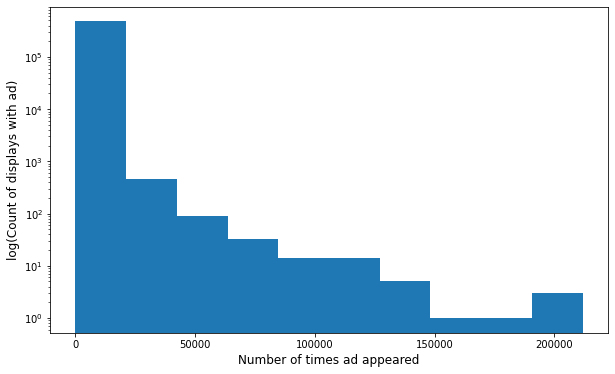

In [9]:
plt.figure(figsize=(10, 6))
plt.hist(ad_likelihood['count'],  log=True)
plt.xlabel('Number of times ad appeared', fontsize=12)
plt.ylabel('log(Count of displays with ad)', fontsize=12)
plt.show()

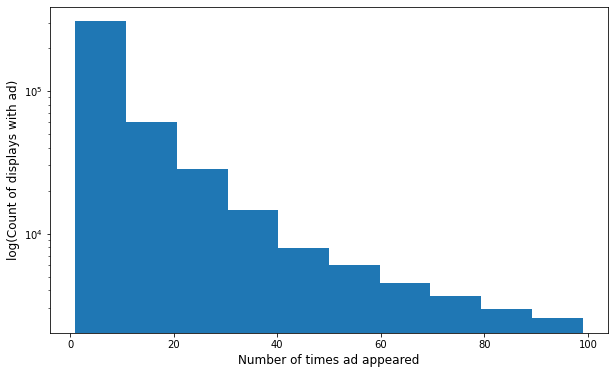

In [10]:
plt.figure(figsize=(10, 6))
plt.hist(ad_likelihood[ad_likelihood['count']<100]['count'],  log=True)
plt.xlabel('Number of times ad appeared', fontsize=12)
plt.ylabel('log(Count of displays with ad)', fontsize=12)
plt.show()